In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torchvision.datasets

#### Data and transforms

In [2]:
image_size = 256

train_transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomRotation(degrees=20),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float16),
        transforms.Normalize(0.5, 0.5, inplace=True),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float16),
        transforms.Normalize(0.5, 0.5, inplace=True),
    ]
)

In [3]:
Aircrafts = torchvision.datasets.FGVCAircraft(root='./', download=True)
len(Aircrafts)

6667

In [4]:
data_classes = Aircrafts.classes

In [5]:
idx_to_class = {k : v for k, v in zip(np.arange(0, 100), data_classes)}

In [6]:
train_data, test_data = torch.utils.data.random_split(Aircrafts, [0.7, 0.3])

In [7]:
len(train_data), len(test_data)

(4667, 2000)

In [8]:
train_data.dataset.transform = train_transform
test_data.dataset.transforms = test_transform

In [9]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, pin_memory=True, shuffle=True, num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=128, pin_memory=True, shuffle=True, num_workers=4
)

In [10]:
imgs, labels = next(iter(train_loader))

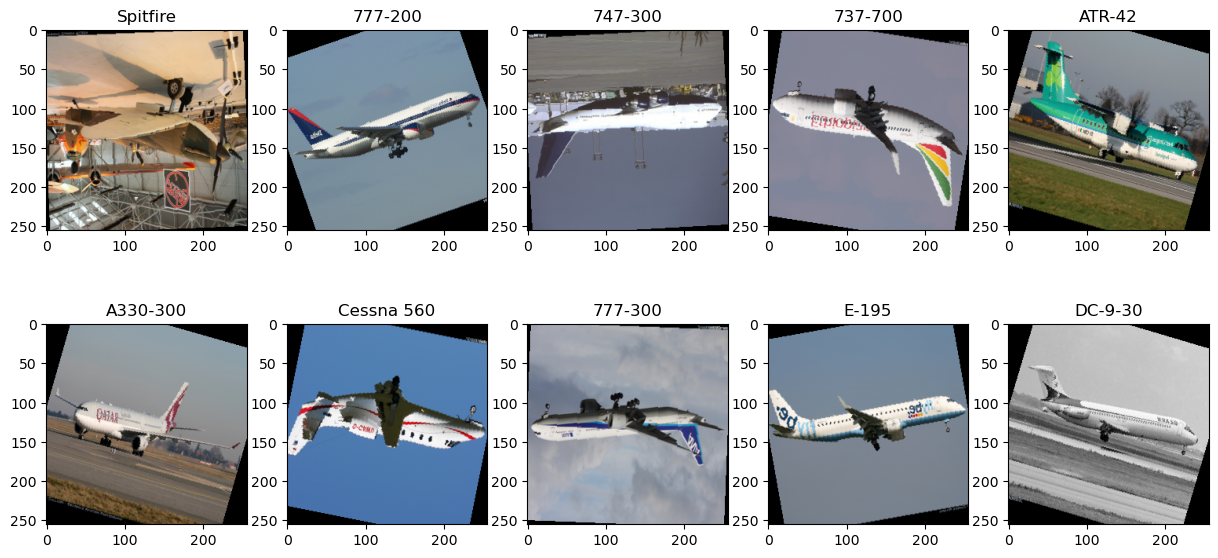

In [11]:
fig, ax = plt.subplots(2, 5, figsize=(15, 7))
for i in range(10):
    ax[i // 5][i % 5].imshow((imgs[i] * 0.5 + 0.5) .to(torch.float32).permute((1, 2, 0)))
    ax[i // 5][i % 5].title.set_text(idx_to_class[labels[i].item()])
plt.show();

#### Let's start with ResNet

In [12]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [13]:
class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.relu,
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
    

    def forward(self, x):
        identity = x.clone()
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out

In [14]:
class ResNet(nn.Module):

    def __init__(self, resblock, layers, out_classes):

        super().__init__()
        self.channesl = 64
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 7, padding=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.mp = nn.MaxPool2d(2, 2)  # 32 -> 16

        self.layer1 = self.make_layer(resblock, 64, layers[0], 1)  # 16
        self.layer2 = self.make_layer(resblock, 128, layers[1], 2)  # 8
        self.layer3 = self.make_layer(resblock, 256, layers[2], 2)  # 4
        self.layer4 = self.make_layer(resblock, 512, layers[3], 2)  # 2
        self.pool = nn.AvgPool2d(7, 2)  # 1
        self.fc = nn.Linear(512, out_classes)

    def make_layer(self, block, channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.channesl != channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.channesl, channels, 1, stride), nn.BatchNorm2d(channels)
            )

        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(block(self.channesl, channels, stride, downsample))
                self.channesl = channels
            else:
                layers.append(block(self.channesl, channels))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.mp(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [15]:
def train_func(tr_l, ts_l, loss_fn, acc_fn, device, epochs=100, lr = 1e-4, model_class = None, model = None):
    if model_class == None and model == None:
        raise ValueError("Model empty")
    train_loss_hist = []
    test_loss_hist = []
    test_acc_hist = []

    

    if model == None:
        model = model_class().half().to(device)
    

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True, eps=1e-2, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)


    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0

        for X, y in tr_l:
            optimizer.zero_grad()

            X, y = X.to(device), y.type(torch.LongTensor).to(device)
            preds = model(X)
            
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        
        scheduler.step()
        train_loss /= len(tr_l)
        train_loss_hist.append(train_loss)


        model.eval()
        test_loss = 0
        test_acc = 0

        

        with torch.no_grad():
            for X, y in ts_l:
                X, y = X.to(device), y.type(torch.LongTensor).to(device)
                preds = model(X)
                test_loss += loss_fn(preds, y).item()
                test_acc += acc_fn(y, torch.argmax(preds, dim=1)).item()

        

        test_loss /= len(ts_l)
        test_acc /= len(ts_l)
        test_loss_hist.append(test_loss)
        test_acc_hist.append(test_acc)

        print(
            f"Epoch: {epoch}\ttrain loss: {loss}\ttest loss:{test_loss}\ttest acc:{test_acc}"
        )
        
    return (model, train_loss_hist, test_loss_hist, test_acc_hist)

In [16]:
model = ResNet(ResBlock, [2, 2, 3, 2], 100).half().to(device)

In [17]:
loss_fn = torch.nn.CrossEntropyLoss()

In [18]:
def acc_fn(y_true, y_preds):
    if y_true.shape != y_preds.shape:
        raise ValueError("Different shapes y_true and y_pred")

    return torch.sum(y_true == y_preds) / len(y_true)

In [19]:
import gc

gc.collect()

torch.mps.empty_cache()

In [20]:
tr_model, tr_loss_hist, ts_loss_hist, ts_acc_hist = train_func(train_loader, test_loader, loss_fn, acc_fn, device, 15, 3e-3, model = model)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0	train loss: 4.55078125	test loss:4.535400390625	test acc:0.02070312504656613
Epoch: 1	train loss: 4.609375	test loss:4.519287109375	test acc:0.024023437523283064


KeyboardInterrupt: 